In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("D:\corona\heart_Disease\heart.csv")
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
data = pd.get_dummies(data, columns=['cp','slope','thal','ca','restecg'], drop_first=True)
data.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,target,cp_1,...,slope_2,thal_1,thal_2,thal_3,ca_1,ca_2,ca_3,ca_4,restecg_1,restecg_2
0,63,1,145,233,1,150,0,2.3,1,0,...,0,1,0,0,0,0,0,0,0,0
1,37,1,130,250,0,187,0,3.5,1,0,...,0,0,1,0,0,0,0,0,1,0
2,41,0,130,204,0,172,0,1.4,1,1,...,1,0,1,0,0,0,0,0,0,0
3,56,1,120,236,0,178,0,0.8,1,1,...,1,0,1,0,0,0,0,0,1,0
4,57,0,120,354,0,163,1,0.6,1,0,...,1,0,1,0,0,0,0,0,1,0


In [4]:
from sklearn.model_selection import train_test_split

X = data.drop('target', axis=1).values
y = data['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Find The Threshold Value

In [6]:
from sklearn.metrics import roc_auc_score, roc_curve

# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

rf_ytrain_pred = rf_model.predict_proba(X_train)
print("RF Train roc-auc:{}".format(roc_auc_score(y_train, rf_ytrain_pred[:,1])))

rf_y_test_pred = rf_model.predict_proba(X_test)
print("RF Test roc-acc:{}".format(roc_auc_score(y_test, rf_y_test_pred[:,1])))

#-----------------------------------------------------------------------------------------------------------------------------


# Logistic Regression
from sklearn.linear_model import LogisticRegression 

lg_model = LogisticRegression()
lg_model.fit(X_train, y_train)

lg_ytrain_pred = lg_model.predict_proba(X_train)
print("LG Train roc-auc:{}".format(roc_auc_score(y_train, lg_ytrain_pred[:,1])))

lg_y_test_pred = lg_model.predict_proba(X_test)
print("LG Test roc-auc:{}".format(roc_auc_score(y_test, lg_y_test_pred[:,1])))

RF Train roc-auc:1.0
RF Test roc-acc:0.9229525862068966
LG Train roc-auc:0.9404704421604468
LG Test roc-auc:0.9364224137931035


# Selection Of Best Threshold For Max Accuracy

In [7]:
pred = []

for model in [rf_model, lg_model]:
    pred.append(pd.Series(model.predict_proba(X_test)[:,1]))
    
final_pred = pd.concat(pred, axis=1).mean(axis=1)
print("Ensemble test roc-auc:{}".format(roc_auc_score(y_test,final_pred)))

Ensemble test roc-auc:0.9342672413793105


In [8]:
# Calculate the roc-curve

False_pos_rate, True_pos_rate, threshold = roc_curve(y_test, final_pred)

threshold

array([1.98734105, 0.98734105, 0.8093662 , 0.79306583, 0.64022815,
       0.6388899 , 0.54064319, 0.52388788, 0.50058005, 0.43507886,
       0.42531386, 0.37355245, 0.30603445, 0.28923214, 0.25421016,
       0.05563267, 0.05232264, 0.00386805])

In [9]:
from sklearn.metrics import accuracy_score

acc = []

for thres in threshold:
    y_pred = np.where(final_pred>thres,1,0) # what ever prediction i am getting and if it is greater than threshold i'll be
                                            # converting as 1 or i'll keep it as 0.
        
        
    acc.append(accuracy_score(y_test,y_pred,normalize=True)) # Then i'll be computing my accuracy score with my y_test and then
                                                             # append the accuracy inside acc list. 
    
acc = pd.concat([pd.Series(threshold), pd.Series(acc)], axis=1)
acc.columns = ['threshold','accuracy']
acc.sort_values(by="accuracy", ascending=False, inplace = True)
acc.head()

,threshold,accuracy
9,0.435079,0.885246
11,0.373552,0.885246
13,0.289232,0.885246
7,0.523888,0.868852
8,0.500580,0.868852


In [10]:
acc

,threshold,accuracy
9,0.435079,0.885246
11,0.373552,0.885246
13,0.289232,0.885246
7,0.523888,0.868852
8,0.500580,0.868852
10,0.425314,0.868852
12,0.306034,0.868852
14,0.254210,0.868852
6,0.540643,0.852459
5,0.638890,0.836066


In [11]:
import matplotlib.pyplot as plt
def plot_roc_curve(False_pos_rate,True_pos_rate):
    plt.plot(False_pos_rate, True_pos_rate, label="ROC")
    plt.plot([0,1],[0,1],color="Red",linestyle="--")
    plt.xlabel("False_Positive_rate")
    plt.ylabel("True_Positive_rate")
    plt.title("ROC Curve")
    plt.legend
    plt.show()

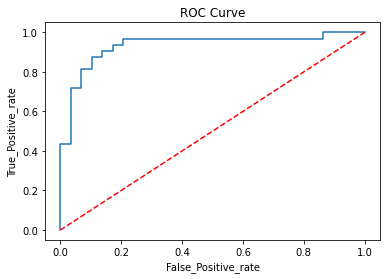

In [12]:
plot_roc_curve(False_pos_rate,True_pos_rate)

# Create A Model with 0.54 Threshold

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score, classification_report

clf = LogisticRegression(class_weight="balanced")
clf.fit(X_train, y_train)
THRESHOLD = 0.54
preds = np.where(clf.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

,0
accuracy,0.852459
recall,0.781250
precision,0.925926
roc_auc_score,0.856142


# Model with Changed threshold value

In [14]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.79      0.93      0.86        29
           1       0.93      0.78      0.85        32

    accuracy                           0.85        61
   macro avg       0.86      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61



In [15]:
print(confusion_matrix(y_test,preds))

[[27  2]
 [ 7 25]]
